<a href="https://colab.research.google.com/github/shubhamv8308/Faulty-Tyres-Classification/blob/main/Faulty_Tyres_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

shubhamvibhut_faulty_tyres_dataset_path = kagglehub.dataset_download('shubhamvibhut/faulty-tyres-dataset')
shubhamvibhut_efficientnetb4_notop_h5_keras_default_1_path = kagglehub.model_download('shubhamvibhut/efficientnetb4_notop.h5/Keras/default/1')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Import necessary libraries
from pathlib import Path
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Set the dataset path
DATASET_PATH = Path("/kaggle/input/faulty-tyres-dataset/Digital images of defective and good condition tyres")

# Define paths for the two classes
DEFECTIVE_PATH = DATASET_PATH / "defective"
GOOD_PATH = DATASET_PATH / "good"

In [ ]:
# Count the number of images in each class
defective_count = len(list(DEFECTIVE_PATH.glob("*")))
good_count = len(list(GOOD_PATH.glob("*")))


In [ ]:
# Calculate class distribution
total_images = defective_count + good_count
defective_percentage = (defective_count / total_images) * 100
good_percentage = (good_count / total_images) * 100


In [ ]:
# Print basic statistics
print(f"Number of defective tyre images: {defective_count}")
print(f"Number of good tyre images: {good_count}")
print(f"Total images: {total_images}")

Number of defective tyre images: 1028
Number of good tyre images: 828
Total images: 1856


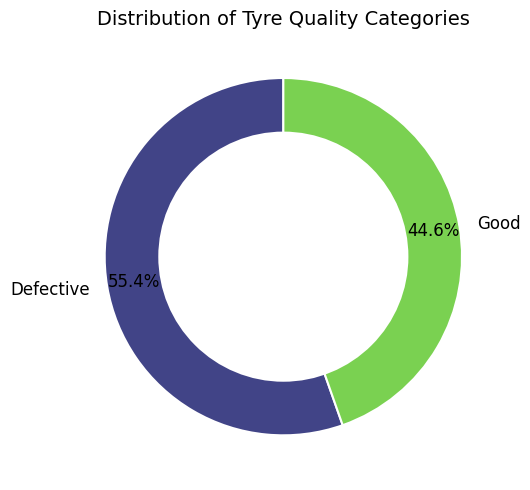

In [ ]:
import matplotlib.pyplot as plt

# Example counts
defective_count = 1028
good_count = 828

# Data for the pie chart
labels = ["Defective", "Good"]
sizes = [defective_count, good_count]
colors = plt.cm.viridis([0.2, 0.8])  # Using Viridis colormap

# Create the pie chart
fig, ax = plt.subplots(figsize=(6, 5))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'},
    pctdistance=0.85
)

# Draw a circle in the center for the donut effect
centre_circle = plt.Circle((0, 0), 0.7, fc='white')
fig.gca().add_artist(centre_circle)

# Set title
ax.set_title("Distribution of Tyre Quality Categories", fontsize=14)

# Improve text appearance
for text in texts + autotexts:
    text.set_color('black')
    text.set_fontsize(12)

plt.tight_layout()
plt.show()


In [ ]:
# Load the dataset using Keras
batch_size = 32
image_size = (224, 224)
dataset = image_dataset_from_directory(
    DATASET_PATH,
    class_names=["defective", "good"],
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=123,
)

Found 1856 files belonging to 2 classes.


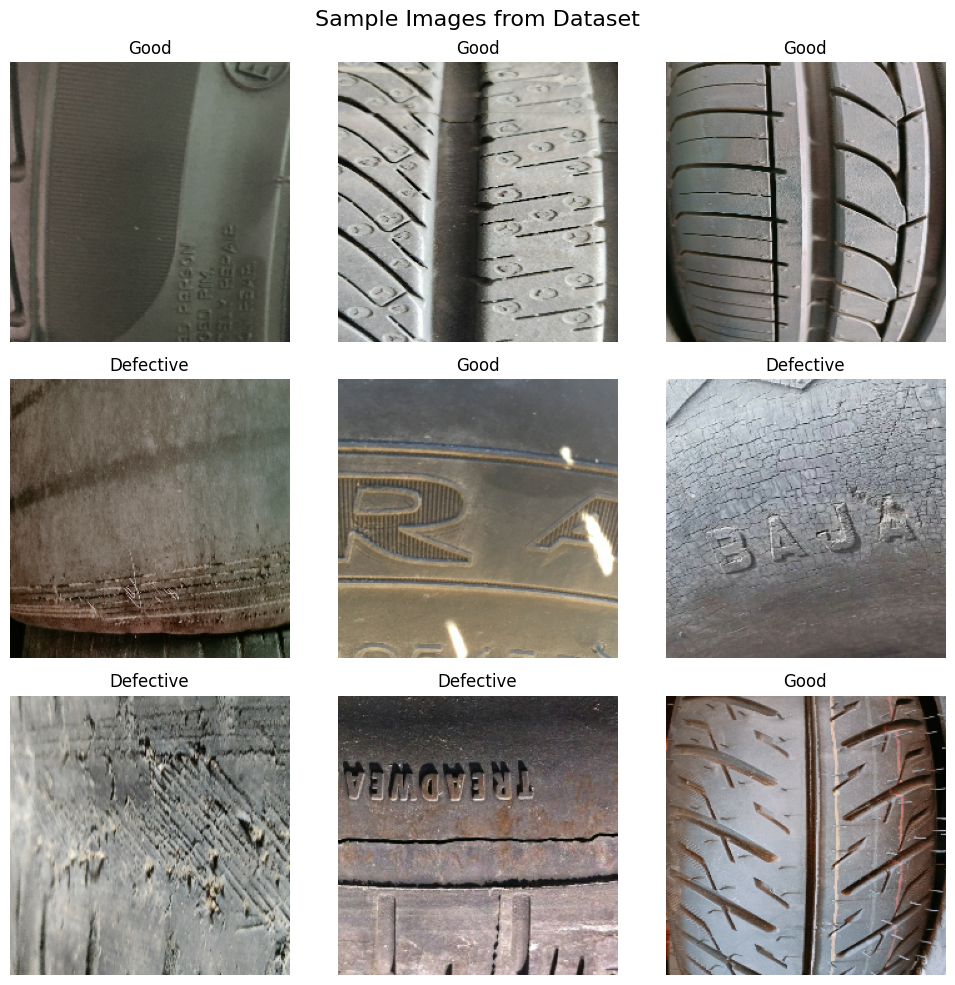

In [ ]:
# Display example images
def plot_sample_images(dataset, title="Sample Images from Dataset"):
    plt.figure(figsize=(10, 10), facecolor="white")
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(9):  # Display first 9 images
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Defective" if labels[i] == 0 else "Good")
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sample_images(dataset)

In [ ]:
# Split dataset into training and validation subsets
def split_data(data_path, valid_ratio=0.2, seed=123):
    # Get paths for defective and good images
    defective_images = glob.glob(str(data_path / "defective" / "*"))
    good_images = glob.glob(str(data_path / "good" / "*"))

    # Combine paths and labels
    paths = np.array(defective_images + good_images)
    labels = np.array([0] * len(defective_images) + [1] * len(good_images))

    # Stratified train-test split
    return train_test_split(
        paths, labels, test_size=valid_ratio, random_state=seed, stratify=labels
    )

train_paths, valid_paths, train_labels, valid_labels = split_data(DATASET_PATH)

In [ ]:
# Create TFRecord serialization function
def serialize_to_tfrecord(paths, labels, output_file, image_size=(224, 224)):
    with tf.io.TFRecordWriter(output_file) as writer:
        for img_path, label in zip(paths, labels):
            # Read and resize the image
            image = tf.io.read_file(img_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, image_size)
            image = tf.cast(image, tf.uint8)

            # Encode the label
            feature = {
                "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

serialize_to_tfrecord(train_paths, train_labels, "train.tfrecord")
serialize_to_tfrecord(valid_paths, valid_labels, "valid.tfrecord")

In [ ]:
# Define function to parse TFRecord files
def parse_tfrecord(serialized_example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.decode_jpeg(parsed_example["image"])
    label = parsed_example["label"]
    return image, label


In [ ]:

# Load datasets
def load_tfrecord_dataset(filename, batch_size=32, shuffle=False):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(parse_tfrecord)
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size)

train_dataset = load_tfrecord_dataset("train.tfrecord", shuffle=True)
valid_dataset = load_tfrecord_dataset("valid.tfrecord")

In [ ]:
# Enhanced Model
base_model = tf.keras.applications.EfficientNetB4(input_shape=(224, 224, 3), include_top=False, weights="/kaggle/input/efficientnetb4_notop.h5/keras/default/1/efficientnetb4_notop.h5")
base_model.trainable = False  # Freeze base model
inputs = keras.Input(shape=(224, 224, 3))
x = layers.RandomFlip()(inputs)
x = layers.RandomRotation(0.2)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)


Epoch 1/10
     47/Unknown 8s 165ms/step - accuracy: 0.8781 - loss: 0.3131

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.8781 - loss: 0.3129 - val_accuracy: 0.8817 - val_loss: 0.2959
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.8974 - loss: 0.2707 - val_accuracy: 0.8817 - val_loss: 0.2846
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8755 - loss: 0.2840 - val_accuracy: 0.8844 - val_loss: 0.2707
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8676 - loss: 0.2933 - val_accuracy: 0.8978 - val_loss: 0.2646
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.8991 - loss: 0.2570 - val_accuracy: 0.8925 - val_loss: 0.2649
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.9082 - loss: 0.2544 - val_accuracy: 0.8978 - val_loss: 0.2611
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.8915 - loss: 0.2730 - val_accuracy: 0.8952 - val_loss: 0.2539
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.9197 - loss: 0.2226 - val_accuracy: 0.903

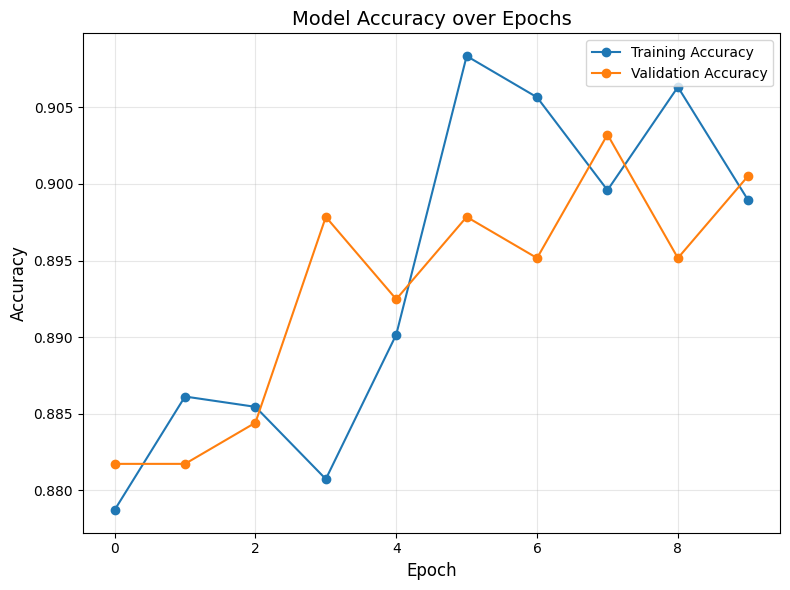

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume `history` is the result of model.fit()
history_df = pd.DataFrame(history.history)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))

# Plot accuracy
plt.plot(history_df.index, history_df["accuracy"], label="Training Accuracy", marker='o')
plt.plot(history_df.index, history_df["val_accuracy"], label="Validation Accuracy", marker='o')

# Add title and labels
plt.title("Model Accuracy over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Add legend
plt.legend(fontsize=10)

# Customize grid
plt.grid(alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()


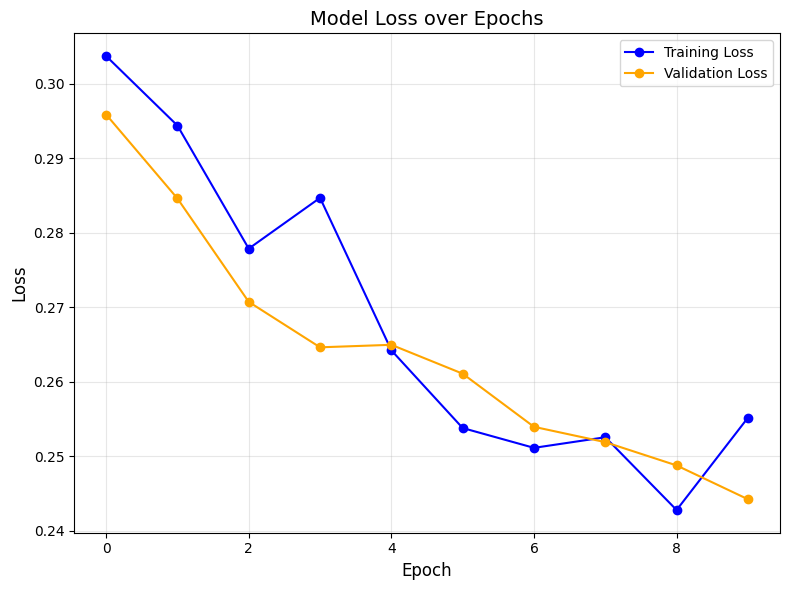

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume `history` is the result of model.fit()
history_df = pd.DataFrame(history.history)

# Plot training and validation loss
plt.figure(figsize=(8, 6))

# Plot loss
plt.plot(history_df.index, history_df["loss"], label="Training Loss", color='blue', marker='o')
plt.plot(history_df.index, history_df["val_loss"], label="Validation Loss", color='orange', marker='o')

# Add title and labels
plt.title("Model Loss over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# Add legend
plt.legend(fontsize=10)

# Customize grid
plt.grid(alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Extract true labels and predicted probabilities from the validation dataset
y_true = []
y_probs = []

# Iterate over the validation dataset to gather true labels and predicted probabilities
for images, labels in valid_dataset:
    y_true.extend(labels.numpy())
    y_probs.extend(model.predict(images).flatten())

y_true = np.array(y_true)
y_probs = np.array(y_probs)
y_pred = (y_probs > 0.5).astype(int)  # Convert probabilities to binary predictions (threshold = 0.5)

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

# Print Metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Accuracy: 0.9005376344086021
Precision: 0.8862275449101796
Recall: 0.891566265060241
F1 Score: 0.888888888888889
ROC-AUC Score: 0.9641478535501228

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       206
           1       0.89      0.89      0.89       166

    accuracy                           0.90       372
   macro avg       0.90      0.90      0.90       372
weighted avg       0.90      0.90      0.90       372



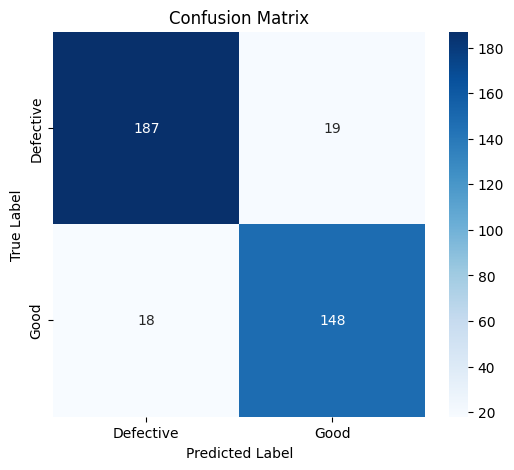

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Defective', 'Good'], yticklabels=['Defective', 'Good'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

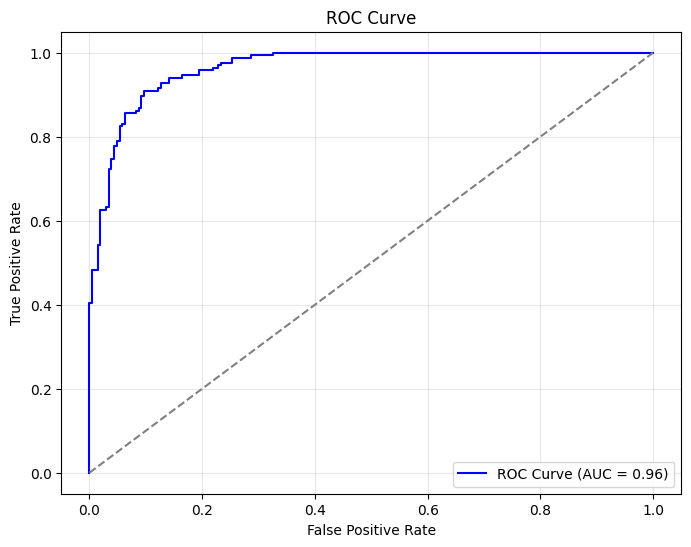

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()